<a href="https://colab.research.google.com/github/S-Kiev95/BK-Upstash/blob/main/Grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalar OSMnx en Google Colab
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.6 MB/s eta 0:00:00


In [3]:
import osmnx as ox
import random
import heapq

In [4]:
place_name = "Salto, Uruguay"
G = ox.graph_from_place(place_name, network_type="drive")

In [5]:
for edge in G.edges:
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

In [6]:
def style_unvisited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#e8a900'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [7]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e"
    )

In [8]:
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        bgcolor = "#18080e"
    )

In [9]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [10]:
def distance(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

In [11]:
def a_star(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distance(node, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1


In [12]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000
    if plot:
        print(f"Distance: {dist:.2f} km")
        print(f"Avg. speed: {sum(speeds)/len(speeds):.1f} km/h")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60:.1f} minutes")
        plot_graph()

In [13]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

=== Ejecutando Dijkstra ===
Iteraciones: 965


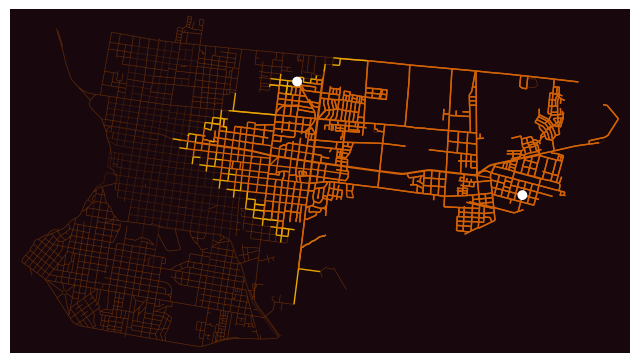

Distance: 5.47 km
Avg. speed: 46.5 km/h
Total time: 7.0 minutes


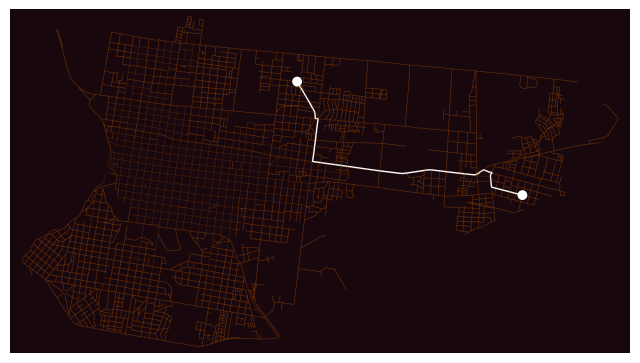

In [14]:
print("=== Ejecutando Dijkstra ===")
dijkstra(start, end, plot=True)
reconstruct_path(start, end, plot=True)


=== Ejecutando A* ===
Iteraciones: 446


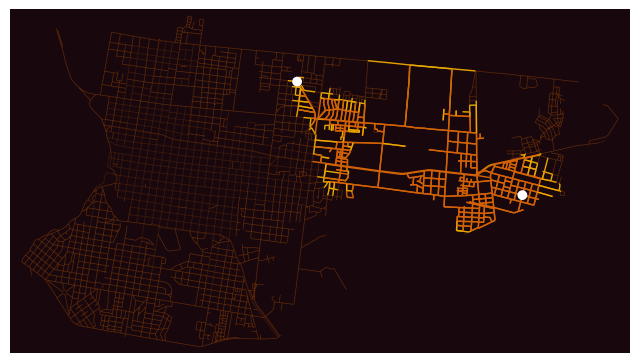

Distance: 5.29 km
Avg. speed: 40.4 km/h
Total time: 7.9 minutes


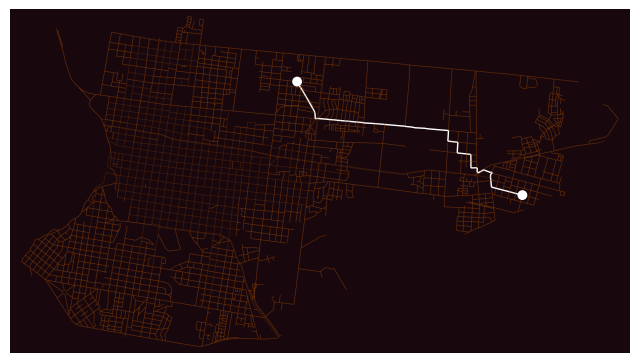

In [15]:
print("\n=== Ejecutando A* ===")
a_star(start, end, plot=True)
reconstruct_path(start, end, plot=True)

In [16]:
# Comparación de rendimiento con múltiples ejecuciones
N = 100 # times to run each algorithm
print(f"\n=== Ejecutando {N} iteraciones para análisis de rendimiento ===")
for edge in G.edges:
    G.edges[edge]["dijkstra_uses"] = 0
    G.edges[edge]["a_star_uses"] = 0


=== Ejecutando 100 iteraciones para análisis de rendimiento ===


In [20]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    # Verificar si existe un camino
    if G.nodes[dest]["previous"] is None and dest != orig:
        if plot:
            print("No se encontró un camino válido entre los nodos seleccionados")
        return False

    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest

    while curr != orig:
        prev = G.nodes[curr]["previous"]
        if prev is None:
            if plot:
                print("Error: Camino incompleto encontrado")
            return False

        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev

    dist /= 1000
    if plot:
        print(f"Distance: {dist:.2f} km")
        print(f"Avg. speed: {sum(speeds)/len(speeds):.1f} km/h")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60:.1f} minutes")
        plot_graph()

    return True

In [21]:
# Comparación de rendimiento con múltiples ejecuciones
N = 100 # times to run each algorithm
print(f"\n=== Ejecutando {N} iteraciones para análisis de rendimiento ===")
for edge in G.edges:
    G.edges[edge]["dijkstra_uses"] = 0
    G.edges[edge]["a_star_uses"] = 0

for i in range(N): # (might take a while, depending on N)
    if (i + 1) % 20 == 0:
        print(f"Progreso: {i + 1}/{N}")
    start = random.choice(list(G.nodes))
    end = random.choice(list(G.nodes))
    dijkstra(start, end)
    reconstruct_path(start, end, algorithm="dijkstra")
    a_star(start, end)
    reconstruct_path(start, end, algorithm="a_star")


=== Ejecutando 100 iteraciones para análisis de rendimiento ===
Progreso: 20/100
Progreso: 40/100
Progreso: 60/100
Progreso: 80/100
Progreso: 100/100


=== Generando mapas de calor ===


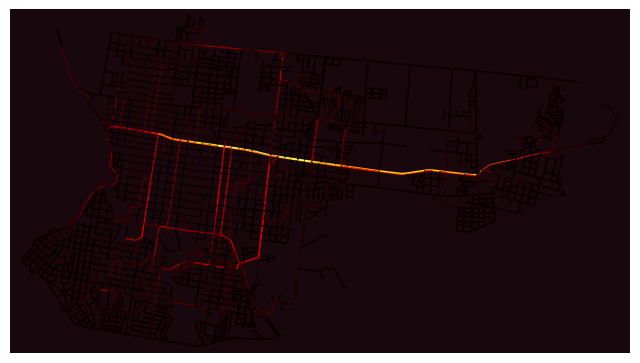

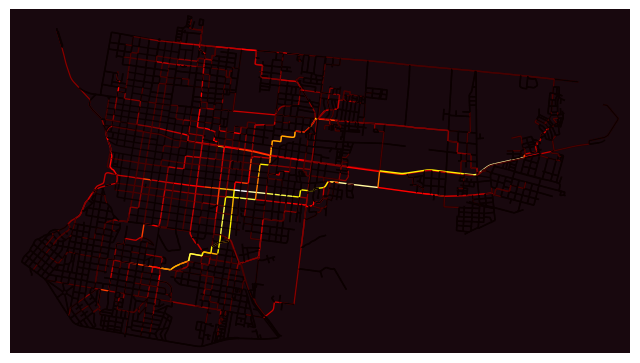

In [18]:
print("=== Generando mapas de calor ===")
plot_heatmap("dijkstra")
plot_heatmap("a_star")